In [36]:
import numba as nb
import numpy as np
from typing import Tuple, Union
from config import Config
cfg = Config()

In [58]:
def _grid_linspace(low: float, high: float, n: int) -> np.ndarray:
    """Helper that always returns float64 equally–spaced grid."""
    return np.linspace(low, high, n, dtype=np.float64)


def build_discretisations(cfg) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (p_disc, v_disc, x_disc) as numpy 1‑D arrays."""
    # ----- v grid (inverse–CDF of standard normal) -----
    from math import sqrt
    from scipy.stats import norm  # lightweight import
    probs = (2 * np.arange(1, cfg.Nv + 1) - 1) / (2 * cfg.Nv)
    v_disc = cfg.v_bar + cfg.sigma_v * norm.ppf(probs)

    # ----- x grid using chiN / chiM -----
    span_x = abs(cfg.chi_N - cfg.chi_M)
    low_x = -max(cfg.chi_N, cfg.chi_M) - cfg.iota * span_x
    high_x = max(cfg.chi_N, cfg.chi_M) + cfg.iota * span_x
    x_disc = _grid_linspace(low_x, high_x, cfg.Nx)

    # ----- p grid (use widest lambda) -----
    lam_max = max(cfg.lambda_N, cfg.lambda_M)
    ph = cfg.v_bar + lam_max * (cfg.I * max(cfg.chi_N, cfg.chi_M) + cfg.sigma_u * 1.96)
    pl = cfg.v_bar - lam_max * (cfg.I * max(cfg.chi_N, cfg.chi_M) + cfg.sigma_u * 1.96)
    span_p = ph - pl
    p_disc = _grid_linspace(pl - cfg.iota * span_p, ph + cfg.iota * span_p, cfg.Np)

    return p_disc, v_disc, x_disc

p_disc, v_disc, x_disc = build_discretisations(cfg)

In [37]:
visit_count = np.zeros((cfg.I, cfg.Np, cfg.Nv), dtype=np.int32)

In [ ]:
Q_table = np.zeros((cfg.I, cfg.Np, cfg.Nv, cfg.Nx), dtype=np.float32)

In [145]:
def initialise_Q_batch(cfg, p_disc, v_disc, x_disc, B: int):
    """
    Build a (B, I, Np, Nv, Nx) tensor: one Q-table per batch path.
    Returns
    -------
    np.ndarray  float32  shape (B, I, Np, Nv, Nx)
    """
    I, Np, Nv, Nx = cfg.I, cfg.Np, cfg.Nv, cfg.Nx
    v_bar, lamN, x_n, rho = cfg.v_bar, cfg.lambda_N, cfg.chi_N, cfg.rho

    # ---- constants over v ----
    Sx      = x_disc.sum()                                  # Σ x_i
    base_v  = v_disc - v_bar - lamN * x_n                   # (Nv,)
    const_v = (Nx * base_v - lamN * (I - 1) * Sx) / ((1 - rho) * Nx)  # (Nv,)

    # ---- core 4-D slab (1, I, Np, Nv, Nx) ----
    core = const_v[None, None, None, :, None] * x_disc[None, None, None, None, :]
    #              ^        ^     ^               broadcast over I, Np, Nx

    # ---- broadcast to include batch ----
    return np.broadcast_to(core, (B, I, Np, Nv, Nx)).astype(np.float32)

# def initialise_Q(cfg, p_disc, v_disc, x_disc):
#     """
#     Build a (I, Np, Nv, Nx) Q-table in one vectorised shot, using
#     parameters directly from the `cfg` object.
#     Returns
#     -------
#     np.ndarray   float32   shape (I, Np, Nv, Nx)
#     """
#     # unpack once for readability
#     I, Np, Nv, Nx = cfg.I, cfg.Np, cfg.Nv, cfg.Nx
#     v_bar   = cfg.v_bar
#     lamN    = cfg.lambda_N
#     x_n     = cfg.chi_N
#     rho     = cfg.rho

#     # ------------------------------------------------------------------
#     # constants that depend only on v-index
#     # ------------------------------------------------------------------
#     Sx        = x_disc.sum()                                # Σ x_i
#     base_v    = v_disc - v_bar - lamN * x_n                 # (Nv,)
#     const_v   = (Nx * base_v - lamN * (I - 1) * Sx)         # (Nv,)
#     const_v  /= (1.0 - rho) * Nx                            # (Nv,)

#     # ------------------------------------------------------------------
#     # broadcast into full Q-table   Q[i,p,v,x] = const_v[v] * x_disc[x]
#     # ------------------------------------------------------------------
#     Q = const_v[None, None, :, None] * x_disc[None, None, None, :]     # (1,1,Nv,Nx)
#     return np.broadcast_to(Q, (I, Np, Nv, Nx)).astype(np.float32)


# # ---- usage -----------------------------------------------------------



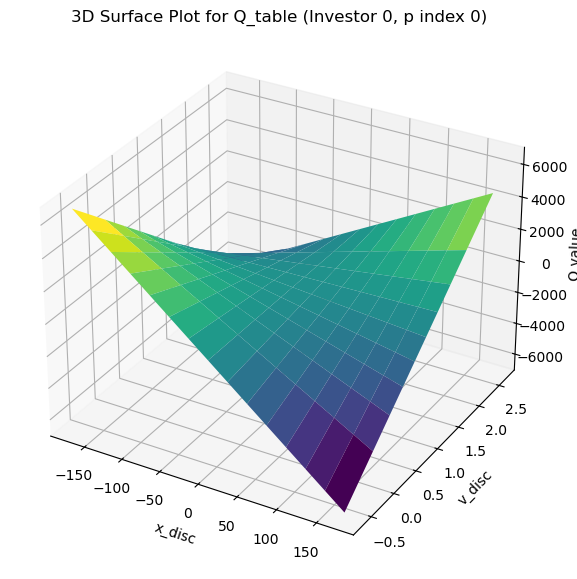

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid over the x_disc and v_disc axes
X, Y = np.meshgrid(x_disc, v_disc)

# Plot the surface using the Q_table slice for investor 0 and p index 0
ax.plot_surface(X, Y, Q_table[0, 0, :, :], cmap='viridis', edgecolor='none')

ax.set_xlabel('x_disc')
ax.set_ylabel('v_disc')
ax.set_zlabel('Q value')
plt.title('3D Surface Plot for Q_table (Investor 0, p index 0)')
# plt.show()
plt.savefig('init_Q_table_plot.png', dpi=300)

In [53]:
class Ring:
    """Circular 1-D buffer that returns a *view* in chronological order."""
    __slots__ = ("buf", "idx")

    def __init__(self, size, dtype=np.float64):
        self.buf = np.zeros(size, dtype=dtype)
        self.idx = 0                 # write pointer

    def add(self, value):
        self.buf[self.idx] = value
        self.idx = (self.idx + 1) % self.buf.size

    def view(self):
        """Return a 1-D **view**: newest element is at index −1."""
        i = self.idx
        return np.concatenate((self.buf[i:], self.buf[:i]), axis=0)

class OnlineOLS:
    """2-var OLS for y = β₀ + β₁ · x   with sliding window."""
    __slots__ = ("ring_x", "ring_y", "Sxx", "Sx", "Sxy", "Sy", "n")

    def __init__(self, size):
        self.ring_x = Ring(size)
        self.ring_y = Ring(size)
        self.Sxx = self.Sx = self.Sxy = self.Sy = 0.0
        self.n = 0                 # samples stored

    def add(self, x, y):
        # remove oldest if buffer full
        if self.n == self.ring_x.buf.size:
            x_old = self.ring_x.buf[self.ring_x.idx]
            y_old = self.ring_y.buf[self.ring_y.idx]
            self.Sxx -= x_old * x_old
            self.Sx  -= x_old
            self.Sxy -= x_old * y_old
            self.Sy  -= y_old
        else:
            self.n += 1

        # add new
        self.ring_x.add(x)
        self.ring_y.add(y)
        self.Sxx += x * x
        self.Sx  += x
        self.Sxy += x * y
        self.Sy  += y

    def coef(self):
        # Solve 2×2 system analytically
        det = self.n * self.Sxx - self.Sx**2
        if det == 0:
            return 0.0, 0.0
        β1 = (self.n * self.Sxy - self.Sx * self.Sy) / det
        β0 = (self.Sy - β1 * self.Sx) / self.n
        return β1, β0
class AdaptiveMarketMaker:
    """
    Vectorised market maker with O(1) update; batched over B paths if yt is array.
    """
    def __init__(self, cfg):
        self.theta = cfg.theta
        m = cfg.Tm
        # OLS trackers
        self.ols_zp = OnlineOLS(m)   # xi_1 from z → p
        self.ols_yv = OnlineOLS(m)   # γ₁, γ₀ from y → v

    def determine_price(self, yt):
        xi_1, _      = self.ols_zp.coef()
        gamma_1, g0  = self.ols_yv.coef()
        lambda_      = (xi_1 + self.theta * gamma_1) / (xi_1**2 + self.theta)
        return g0 + lambda_ * yt

    def update(self, vt, pt, zt, yt):
        """vt, pt, zt, yt can be scalars **or 1-D vector of batch size B**."""
        # flatten in case of numpy 0-D
        vt = np.asarray(vt).ravel()
        pt = np.asarray(pt).ravel()
        zt = np.asarray(zt).ravel()
        yt = np.asarray(yt).ravel()
        # loop only over batch dimension (tiny)
        for x, y in zip(zt, pt):
            self.ols_zp.add(x, y)
        for x, y in zip(yt, vt):
            self.ols_yv.add(x, y)


In [157]:
rng     = np.random.default_rng(123)
T       = 5000
B       = 1000
noise   = rng.normal(0, cfg.sigma_u, (B,T))
v_path  = rng.integers(0, cfg.Nv, (B, T))

p_idx   = rng.integers(0, cfg.Np, (B,))   # start price index
v_idx   = v_path[:, 0]                     # (B,)  initial value indices

# ---------- market-maker ----------
mm = AdaptiveMarketMaker(cfg)              # one shared MM

# ---------- discretisations ----------
p_disc, v_disc, x_disc = build_discretisations(cfg)

# ---------- per-path Q, visit, last-opt ----------
Q_table     = initialise_Q_batch(cfg, p_disc, v_disc, x_disc, B)  # (B,I,Np,Nv,Nx)
visit_count = np.zeros((B, cfg.I, cfg.Np, cfg.Nv),     dtype=np.int32)
last_opt    = -np.ones((B, cfg.I, cfg.Np, cfg.Nv),     dtype=np.int16)
conv_ctr    = np.zeros((B, cfg.I),             dtype=np.int32)

# helper index tensors
batch_ix = np.arange(B)[:, None]           # shape (B,1)
agent_ix = np.arange(cfg.I)[None, :]           # shape (1,I)

# ---------- initial memory (greedy value) ----------
greedy  = Q_table[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]].argmax(-1)   # (B,I)
memory  = np.take_along_axis(
            Q_table[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]],
            greedy[..., None], axis=-1
         )[..., 0]                                                              # (B,I)

# ---------- main loop ----------
for t in range(T - 1):
    u_t = noise[:, t]                             # (B,)

    # ε-greedy
    eps      = np.exp(-cfg.beta * visit_count[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]])
    visit_count[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]] += 1

    explore  = rng.random((B, I)) < eps           # (B,I)
    greedy   = Q_table[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]].argmax(-1)
    randomA  = rng.integers(0, cfg.Nx, (B, cfg.I))
    action   = np.where(explore, randomA, greedy)           # (B,I)

    # trades & market maker
    y_sum = x_disc[action].sum(axis=1) + u_t               # (B,)
    p_val = mm.determine_price(y_sum)                      # float or (B,) if vectorised MM
    z_val = cfg.xi * (p_val - cfg.v_bar)
    mm.update(v_disc[v_idx], p_val, z_val, y_sum)

    # rewards & Bellman
    profit   = x_disc[action] * (v_disc[v_idx,None] - p_val[:,None])    # (B,I)
    best     = Q_table[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]].max(-1)
    bellman  = (1-cfg.alpha)*memory + cfg.alpha*(profit + cfg.rho*best)

    # write back
    Q_table[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None], action] = bellman
    memory = bellman

    # convergence counter (optional)
    changed = greedy != last_opt[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]]
    reset   = changed.any(axis=1)
    conv_ctr[reset]  = 0
    conv_ctr[~reset] += 1
    last_opt[batch_ix, agent_ix, p_idx[:,None], v_idx[:,None]] = greedy

    # advance indices for next step
    v_idx = v_path[:, t+1]                                              # (B,)
    p_idx = np.abs(p_disc[:,None] - p_val).argmin(axis=0)               # (B,)

In [158]:
profit

array([[-468.69474676, -133.91278479],
       [-223.40297704,  186.16914753],
       [ 113.41516182,  -85.06137136],
       ...,
       [  49.00652222,  -49.00652222],
       [   0.        , -202.0353519 ],
       [  53.91146086,  -40.43359564]])

In [ ]:
rng     = np.random.default_rng(123)
T       = 500
B       = 100
noise   = rng.normal(0, cfg.sigma_u, T)
v_path  = rng.integers(0, cfg.Nv, T)

p_idx   = rng.integers(0, cfg.Np)   # start price index
v_idx   = v_path[0]

mm      = AdaptiveMarketMaker(cfg)
memory  = np.argmax(Q_table[:, p_idx, v_idx, :], axis=-1)

for t in range(T-1):
    u    = noise[t]

    eps  = np.exp(-cfg.beta * visit_count[:, p_idx, v_idx])
    visit_count[:, p_idx, v_idx] += 1

    explore = rng.random(cfg.I) < eps
    greedy  = Q_table[:, p_idx, v_idx].argmax(axis=1)
    action  = np.where(explore,
                       rng.integers(0, cfg.Nx, cfg.I),
                       greedy)

    y       = x_disc[action].sum() + u
    p_val   = mm.determine_price(y)
    z       = cfg.xi * (p_val - cfg.v_bar)
    mm.update(v_disc[v_idx], p_val, z, y)

    profit  = x_disc[action] * (v_disc[v_idx] - p_val)
    learn   = Q_table[:, p_idx, v_idx].max(axis=1)
    bellman = (1-cfg.alpha)*memory + cfg.alpha*(profit + cfg.rho*learn)
    Q_table[np.arange(cfg.I), p_idx, v_idx, action] = bellman
    memory  = Q_table[np.arange(cfg.I), p_idx, v_idx, action]

    # advance indices
    v_idx   = v_path[t+1]
    p_idx   = np.abs(p_disc - p_val).argmin()   # map price→index


In [140]:
memory

array([2501.1343, 2970.0095], dtype=float32)

In [ ]:
import numpy as np
rng = np.random
T = 500
noise = np.random.normal(0, cfg.sigma_u, T)
value = np.random.randint(0, cfg.Nv, T)

p = value[0]

mm = AdaptiveMarketMaker(cfg)
memory = np.argmax(Q_table[:, p, p, :], axis = -1) # (I,)
v = value[0]
for t in range(T - 1):
    u = noise[t]
    
    # exporation-exploitation
    eps = np.exp(-cfg.beta * visit_count[:, p, v])
    visit_count[:, p, v] += 1
    explore = rng.random(cfg.I) < eps
    greedy = np.argmax(Q_table[:, p, v, :], axis = -1)
    action = np.where(explore, rng.randint(0, cfg.Nx, cfg.I), greedy) # (I,)

    # get price from market maker
    y = x_disc[action].sum() + u
    p = mm.determine_price(y)
    z = cfg.xi * (p - cfg.v_bar)
    mm.update(v, p, z, y)

    # update Q-table
    profit = x_disc[action] * (v_disc[v] - p) # (I,)
    # change p from to index
    
    learning = np.argmax(Q_table[:, p, v, :], axis = -1)
    bellman = (1 - cfg.alpha) * memory + cfg.alpha * (profit + cfg.rho * learning)
    # update Q-table
    Q_table[np.arange(cfg.I), p, v, action] = bellman


    # new value
    v = value[t + 1]
    break




IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [137]:
p

0.0

In [134]:
# Q_table[:,1,0,action] = bellman
Q_table[np.arange(cfg.I),0,v,action]

array([-0.54942983,  0.27471492], dtype=float32)

In [135]:
bellman

array([-0.54942984,  0.27471492])

In [86]:
value[0]

6

In [87]:
v_disc

array([-0.64485363, -0.03643339,  0.32551025,  0.61467953,  0.87433865,
        1.12566135,  1.38532047,  1.67448975,  2.03643339,  2.64485363])